In [1]:
from ocpy import OCP, DDPSolver, iLQRSolver, MPC
from ocpy import symutils

import numpy as np
import sympy as sym
from sympy import sin, cos, tan, exp, log, ln, sinh, cosh, tanh, diff, sqrt
from IPython.display import display, Math


In [2]:
# Dimensions of state and input
n_x = 4
n_u = 1
sim_name = 'cartpole'
# Define ocp class
ocp = OCP(n_x, n_u, sim_name)
# Get symbols
t = ocp.get_t()
x = ocp.get_x()
u = ocp.get_u()

In [3]:
# Symbolic expressions of constants.
m_c, m_p, l, g, u_min, u_max, u_eps = ocp.define_scalar_constants(
         [('m_c', 2), ('m_p', 0.1), ('l', 0.5), ('g', 9.80665), 
          ('u_min', -15),  ('u_max', 15), ('u_eps', 0.001)]
          )
# Cost weight
q = ocp.define_vector_constant('q', [2.5, 10, 0.01, 0.01])
r = ocp.define_vector_constant('r', [1])
q_f = ocp.define_vector_constant('q_f', [2.5, 10, 0.01, 0.01])
Q = sym.diag(*q)
Qf = sym.diag(*q_f)
R = sym.diag(*r)
# Reference state. 
x_ref = ocp.define_vector_constant('x_ref', [0, np.pi, 0, 0])


In [4]:
# State of equation.
f = ocp.get_zero_vector(n_x)
f[0] = x[2]
f[1] = x[3]
f[2] = (u[0] + m_p*sin(x[1])*(l*x[1]*x[1] + g*cos(x[1])) )/( m_c+m_p*sin(x[1])*sin(x[1]) )
f[3] = (-u[0] * cos(x[1]) - m_p*l*x[1]*x[1]*cos(x[1])*sin(x[1]) 
        - (m_c+m_p)*g*sin(x[1]) )/( l*(m_c + m_p*sin(x[1])*sin(x[1])))
# Log barrier for control limits.
u_barrier = sum(-ln(u[i] - u_min) - ln(u_max - u[i]) for i in range(n_u)) * 1e-5
# Stage cost and terminal cost.
l = (x - x_ref).T * Q * (x - x_ref) + u.T * R * u
l = l[0, 0] + u_barrier
lf = (x - x_ref).T * Qf * (x - x_ref)
# Display state equation and cost function
display(Math(r"\dot{x} = f(x, u, t) \equiv %s" % sym.latex(f)))
display(Math(r"l(x, u) = %s" % sym.latex(l)))
display(Math(r"l_f(x) = %s" % sym.latex(lf)))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [5]:
ocp.define_unconstrained(f, l, lf)


In [7]:
# Hand over ocp to solver.
# solver = DDPSolver(ocp)
solver = iLQRSolver(ocp)


Initializing solver...
Initialization Done.


In [8]:
T = 2.0
N = 50
solver.set_horizon(T, N)

us_guess = np.zeros((N, n_u))
solver.set_guess(us_guess=us_guess)

t0 = 0.0
x0 = np.array([0.0, 0.0, 0.0, 0.0])
solver.set_initial_condition(t0, x0)


In [9]:
# Model Predictive Control class
mpc = MPC(solver)


In [10]:
# Initialize mpc.
mpc.init_mpc()


------------------- RESULT -------------------
solver: iLQR
Final state: [-1.57866631e-02  3.14229211e+00  1.97770984e-02  9.04861780e-04]
Average computation time: 0.001032 [s]
Average number of iterations: 1.538731
----------------------------------------------
Data are saved at /home/ohtsukalab/src/ocpy/log_mpc/cartpole


'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


Graphs are saved at /home/ohtsukalab/src/ocpy/log_mpc/cartpole/result.pdf


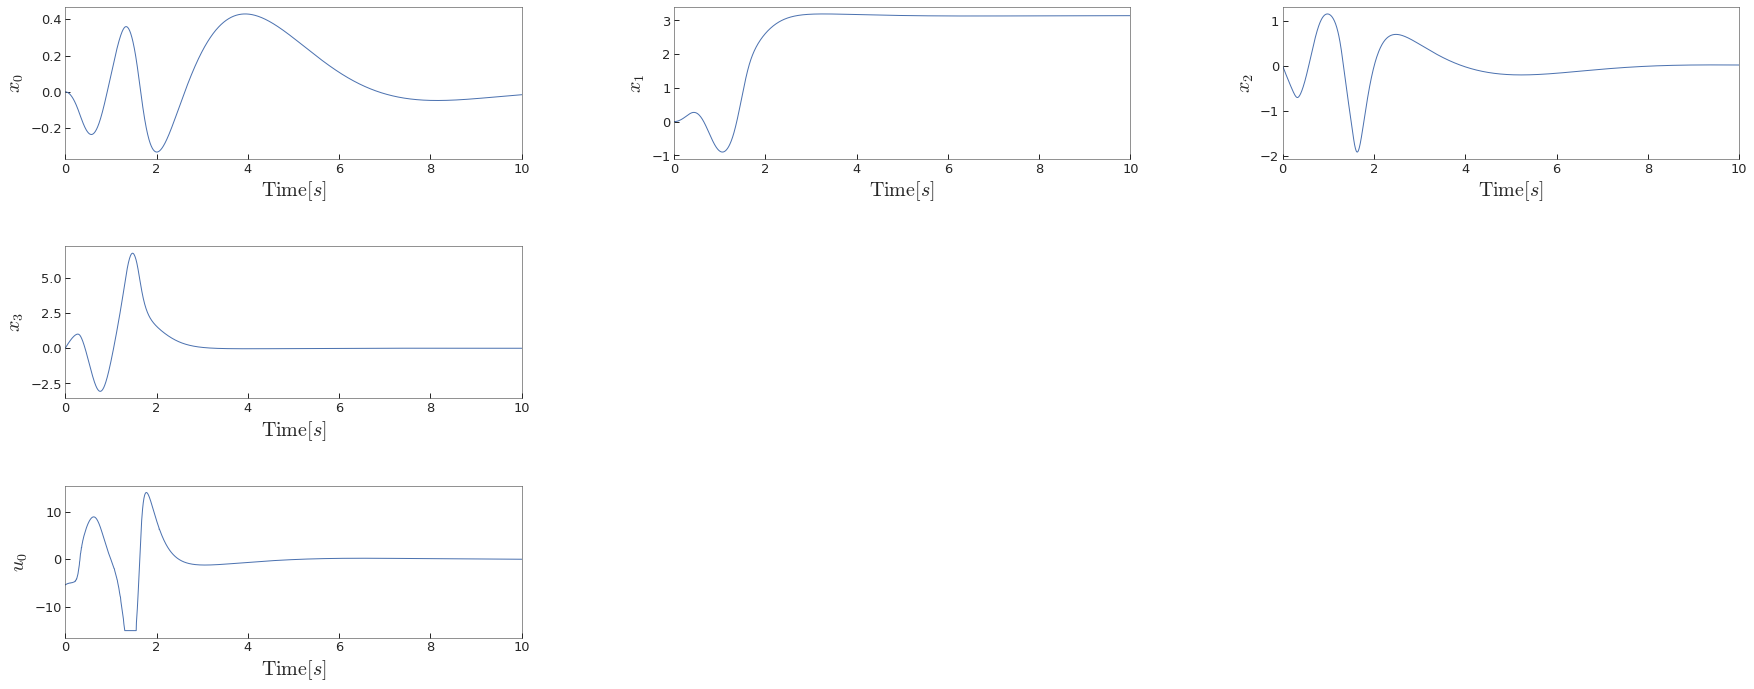

In [11]:
# Run mpc.
xs, us, ts = mpc.run(T_sim=10, sampling_time=0.005, max_iters_mpc=5, result=True, log=True, plot=True)


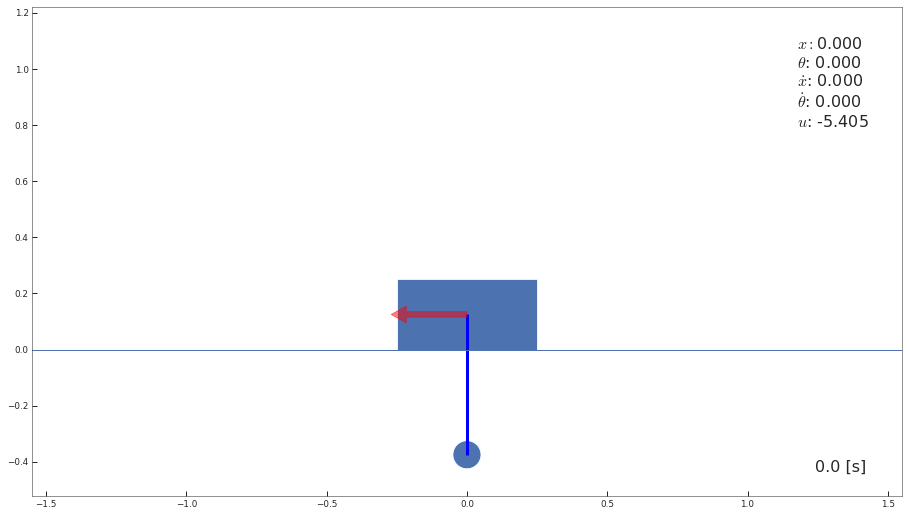

In [12]:
%matplotlib inline
# visualize
from ocpy.animator import CartPoleAnimator
animator = CartPoleAnimator(mpc.get_log_directory(), sim_name)
animator.generate_animation(save=False, skip_rate=10)
